# TP53 Methods - Sweep of Clinical Data

### Following our protein analysis, we looked for any correlations within our clinical data that were worth exploring.

### Standard imports, including CTPAC package

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import math
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


## Set-up of Initial Dataframes and Variables

In [2]:
gene = 'TP53'
protein = 'TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
clinical_full = CPTAC.get_clinical() 

### Creating a dataframe of patient ID's for patients that have mutation(s) in the TP53 hotspot

In [3]:
# A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del', 'p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Patient_Id']

### Creating a modified clinical dataframe that designates mutation type

In [4]:
# Creating this dataframe to join with the clinical data to include mutation type
loc_compare = CPTAC.compare_mutations(proteomics, protein, gene)

# Joining the two dataframes and selecting only for patients with tumors
clinical_full = clinical_full.join(loc_compare)
clinical_full = clinical_full.loc[clinical_full['Sample_Status'] == 'Tumor']

# Changing the index to be the patient's universal CPTAC ID
clinical_full = clinical_full.set_index('Proteomics_Participant_ID')

# Designating the type of TP53 mutation. True = TP53 Hotspot Mutation. False = TP53 Non-Hotspot Mutation. WT = No TP53 Mutation
clinical_full['Within_Hotspot'] = False
clinical_full.loc[hotspot_patients, 'Within_Hotspot'] = True
clinical_full.loc[clinical_full['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'WT'

## Clinical Data Chi-Square Analysis

### Bonferroni correction of p-value significance cuttoff for chi-square analysis

In [5]:
# Calculating the number of chi-square analyses to be run based on data type
Chi_Tests = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'object':
        Chi_Tests += 1
pcutoff = 0.05/Chi_Tests
print ('p-value cutoff is ' + str(pcutoff))           

p-value cutoff is 0.00078125


### Running the chi-square analysis

In [6]:
# Going through every column of our clinical dataframe
for feature in clinical_full:
    # Only performing the chi-square analysis on columns with the data type of 'object'
    if str(clinical_full[feature].dtypes) == 'object':
        # Creating the table to be used in the chi-square analysis
        chi_clinical = pd.crosstab(clinical_full[feature], clinical_full['Within_Hotspot'])
        chi_test = scipy.stats.chi2_contingency(observed = chi_clinical)
        if str(feature) != 'Within_Hotspot':
            # Printing significant values and the table used in the chi-square analysis
            if chi_test[1] <= pcutoff:
                print(feature)
                print ('p-value = ' + str(chi_test[1]))
                chi_test = pd.crosstab(clinical_full[feature], clinical_full['Within_Hotspot'])
                print (str(chi_test) + '\n')

Histologic_type
p-value = 4.150339657441851e-10
Within_Hotspot   False  True  WT
Histologic_type                 
Endometrioid         4     5  73
Serous               4     6   0

p53
p-value = 5.715851430351134e-06
Within_Hotspot        False  True  WT
p53                                  
Cannot be determined      5     7  66
Loss of expression        2     0   0
Normal                    1     1   4
Overexpression            0     3   1
Unknown                   0     0   2

CNV_clustering
p-value = 2.997004747985085e-11
Within_Hotspot  False  True  WT
CNV_clustering                 
CNV-high            6     8   3
CNV-low             2     3  70

Genomic_subtype
p-value = 5.80309444201251e-10
Within_Hotspot   False  True  WT
Genomic_subtype                 
CNV-high             6     8   2
CNV-low              0     2  42
MSI-H                1     1  23
POLE                 1     0   6

Mutation
p-value = 2.818376134812488e-26
Within_Hotspot     False  True  WT
Mutation          

# Clinical Data t-test Analysis

### Bonferroni correction of p-value significance cuttoff for t-test analysis

In [7]:
# Calculating the number of t-test analyses to be run based on data type
t_tests = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        t_tests += 1
pcutoff = 0.05/t_tests
print ('p-value cutoff is ' + str(pcutoff))

p-value cutoff is 0.00045454545454545455


### Running the t-test analysis

In [8]:
# Creating dataframes for the Tp53 hotspot mutations vs. wildtype TP53 comparison
TP53_Hotspot_Mutation = clinical_full.loc[clinical_full['Within_Hotspot'] == True]
Wildtype_TP53 = clinical_full.loc[clinical_full['Within_Hotspot'] != 'WT']

# TP53 Hotspot Mutations vs. Wildtype TP53 t-test
significant_results = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(TP53_Hotspot_Mutation[feature].dropna(axis=0), Wildtype_TP53[feature].dropna(axis = 0))
        # Printing significant values
        if ttest[1] <= pcutoff:
            significant_results += 1
            print(feature)
            print('p-value = ' + str(ttest[1]))
            print('t-test statistic = ' + str(ttest[0]) + '\n')
            
# Printing the number of significant results
if significant_results == 0:
    print('**There are no significant results based on this comparison**')
else:
    print('**There are ' + str(significant_results) + ' significant results based on this comparison**')

**There are no significant results based on this comparison**


In [9]:
# Creating dataframes for the Mutated TP53 vs Wildtype TP53 comparison        
Wildtype_TP53 = clinical_full.loc[clinical_full['Within_Hotspot'] == 'WT']
Mutated_TP53 = clinical_full.loc[clinical_full['Within_Hotspot'] != 'WT']

# Mutated TP53 vs. Wildtype TP53 t-test
significant_results = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(Mutated_TP53[feature].dropna(axis=0), Wildtype_TP53[feature].dropna(axis = 0))
        # Printing significant values
        if ttest[1] <= pcutoff:
            significant_results += 1
            print(feature)
            print('p-value = ' + str(ttest[1]))
            print('t-test statistic = ' + str(ttest[0]) + '\n')

# Printing the number of significant results
if significant_results == 0:
    print('**There are no significant results based on this comparison**')
else:
    print('**There are ' + str(significant_results) + ' significant results based on this comparison**') 

LVSI
p-value = 9.353329194129372e-05
t-test statistic = 4.094936377650802

Estrogen_Receptor_%
p-value = 0.00042923872905638034
t-test statistic = -3.9013514769411093

ER_ESR1
p-value = 0.0004152332849383306
t-test statistic = -3.6667810150952125

Pathway_activity_JAK.STAT
p-value = 9.50381646163015e-07
t-test statistic = 5.2639858080111805

Pathway_activity_p53
p-value = 4.789558788120671e-06
t-test statistic = -4.867754601291717

TP53_TP53
p-value = 0.0
t-test statistic = inf

TP53_pathway
p-value = 2.360221911525022e-19
t-test statistic = 11.49669139550498

PI3K_PTEN
p-value = 1.2255019773696922e-07
t-test statistic = -5.746759416932983

PI3K_pathway
p-value = 3.708295292741601e-06
t-test statistic = -4.931482625895862

CNV_index
p-value = 4.429699169584611e-11
t-test statistic = 7.4946355891948455

Mutation_signature_C>G
p-value = 1.0815480211565519e-09
t-test statistic = 6.806358247218956

Mutation_signature_C>T
p-value = 0.00020963380557055628
t-test statistic = -3.86464967114693

## Plotting columns from the clinical data found to be significant after t-test results

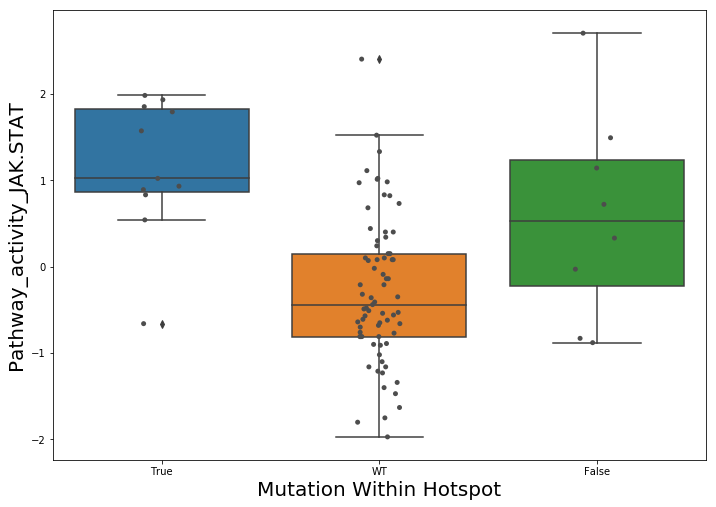

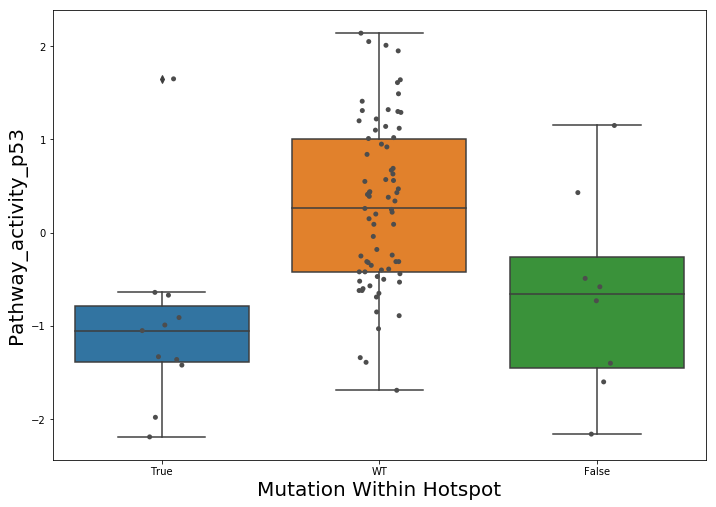

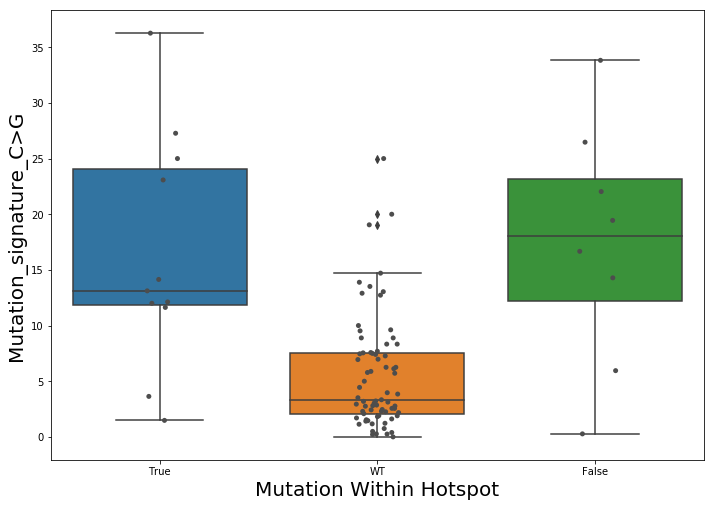

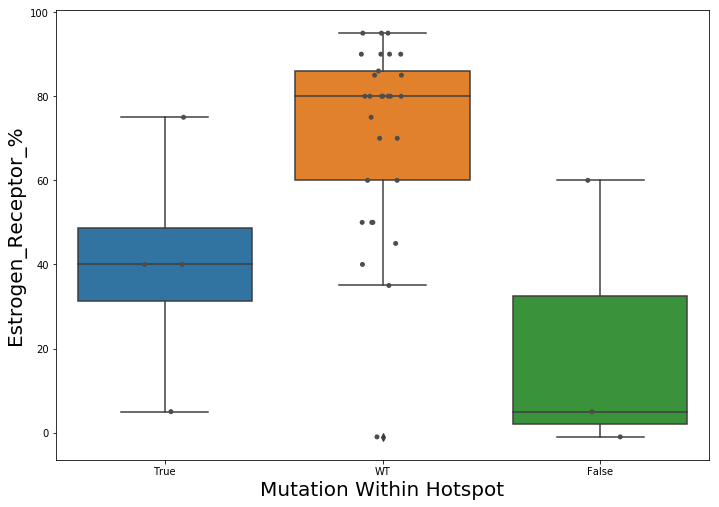

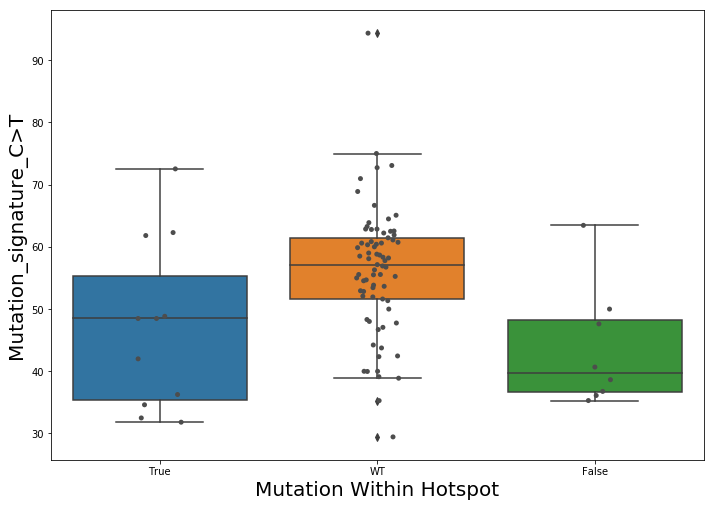

In [10]:
# We compiled this list of 5 clinical data columns based on which data was able to be plotted
sig_list = ['Pathway_activity_JAK.STAT', 'Pathway_activity_p53', 'Mutation_signature_C>G', 'Estrogen_Receptor_%', 'Mutation_signature_C>T']

# Plotting each of the clinical data columns from our list
for feature in sig_list:
    Y_var = feature
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize = a4_dims)
    boxplt = sns.boxplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, ax = ax)
    boxplt = sns.stripplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, jitter = True, color = '.3')
    boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
    boxplt.set_ylabel(Y_var, fontsize='20')
    plt.show()